### Probabilistic Programming Project - Recommendation System using HPF
Sirbu Oana Adriana - Group 407/AI

In [1]:
# import all the necessary modules along the notebook
import pymc3 as pm
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

#### Section 1. Inspect the chosen dataset

The dataset can be found at the following link: https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset

Here I load data from CSV files into Pandas Dataframes using pandas library

In [2]:
all_users_df = pd.read_csv('Users.csv')
all_books_df = pd.read_csv('Books.csv')
all_ratings_df = pd.read_csv('Ratings.csv')

/var/folders/x1/s3cbwwp561757zrxxwm_j8h00000gn/T/ipykernel_2226/3025410568.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  all_books_df = pd.read_csv('Books.csv')


Followed by the conversion of the 'Year-Of-Publication' column to numeric data type, to avoid the previous warning

In [3]:
all_books_df['Year-Of-Publication'] = pd.to_numeric(all_books_df['Year-Of-Publication'], errors='coerce')
# this is only for checking the data types, to see if it worked (P.S: returns the expected output)
print(all_books_df.dtypes)

ISBN                    object
Book-Title              object
Book-Author             object
Year-Of-Publication    float64
Publisher               object
Image-URL-S             object
Image-URL-M             object
Image-URL-L             object
dtype: object


Further inspect the chosen dataset, print the shape of each Dataframe

In [4]:
print(all_users_df.shape)
print(all_books_df.shape)
print(all_ratings_df.shape)

(278858, 3)
(271360, 8)
(1149804, 3)


This is to have a glimpse of the data (I concluded that the Book-Ratings will be used as inputs for the collaborative filtering method, along the corresponding users and books)

In [5]:
print(all_ratings_df.head())

   User-ID        ISBN  Book-Rating
0   276725  034545104X            0
1   276725  0060530421            0
2   276725  0449243141            5
3   276725  0385491808            7
4   276726  0155061224            5


#### Section 2. Prepare the sanity check dataset

In the following cell I will prepare data for the sanity check. The users and ISBNs were manually selected. For this selection, I took into account the users who have provided a reasonable number of ratings and also have common books between some of them. For recommendation systems, it is common to have a sparse matrix (containing many zero values), but having an entire null matrix wouldn't provide our model any information to learn from. Anyway, I also chose 2 non so popular books to see how the model handles them.

In [6]:
# lists of manually chosen users ids and books isbns that are correlated
manually_selected_user_ids = [276725, 2313, 8680, 10314, 77480, 98391, 112199, 123981, 128045, 138543]  
manually_selected_isbns = ['034545104X', '0374292035', '0020442602', '0812516125', '0385491808', '0345339738', '0060530421', '0451162145', '0425178552', '0345348036']  

# actually extract information for the selected users based on their ids
selected_users = all_users_df[all_users_df['User-ID'].isin(manually_selected_user_ids)]
# same for the books
selected_books = all_books_df[all_books_df['ISBN'].isin(manually_selected_isbns)]

# first, I merge all ratings with selected users
selected_interactions_matrix = pd.merge(all_ratings_df, selected_users, on='User-ID')
# second, I merge the previous result with the selected books to help me later form the interaction matrix
selected_interactions_matrix = pd.merge(selected_interactions_matrix, selected_books, on='ISBN')

# and finally create the interaction matrix for the manually selected users and books
int_matrix_selected = selected_interactions_matrix.pivot_table(index='User-ID', columns='ISBN', values='Book-Rating')
int_matrix_selected = int_matrix_selected.fillna(0) # this is to handle missing or NaN values
int_matrix_arr_selected = int_matrix_selected.values

In [7]:
# simply print the obtained interaction matrix for selected components
print(int_matrix_arr_selected)

[[ 9.  0.  6.  9.  5.  0.  0.  0.  0.  0.]
 [ 3.  6.  0.  7.  5.  8.  0.  6.  0.  0.]
 [ 0.  0.  0.  0.  9.  0.  7.  5.  5.  0.]
 [ 0.  0.  9.  0.  8.  0.  4.  8.  9.  0.]
 [ 0.  5.  0.  0.  9.  0.  0.  0.  0.  9.]
 [ 0.  0.  0.  0.  6.  0.  0.  0.  0.  0.]
 [ 8.  0.  0.  0.  0.  0.  0.  0.  0.  5.]
 [ 0.  0.  8.  0.  7.  0.  0.  0.  7.  0.]
 [ 0.  8. 10.  0.  0.  0.  9.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  7.  0.  0.  0.]]


For a better visualization, I chose to create a comprehensive heatmap.

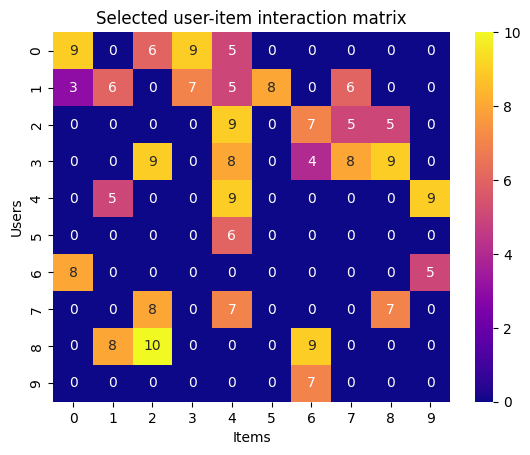

In [8]:
# create the heatmap using seaborn module
sns.heatmap(int_matrix_arr_selected, cmap='plasma', annot=True)
# choose a title for the map
plt.title('Selected user-item interaction matrix')
plt.xlabel('Items')
plt.ylabel('Users')
plt.show()

I introduce the observed data variable that will be used in the model for the sanity check. It is esentially the previously computed interaction matrix in array format.

In [9]:
# store the interaction matrix as observed data (later used in the model) before splitting
obs_data = int_matrix_arr_selected

# check the number of users and items
n_users, n_items = obs_data.shape
print(n_users, n_items)

10 10


#### Section 3. HPF model implementation

Next one is an actual implementation of the HPF model. 

Comments that partially explain the way I implemented the model (more comments in the code): 
1. The observed interactions are modeled using a Poisson distribution because it is especially designed to count data (in my case the number of user-item interactions).
2. The hierarchical structure of the model helps to handle uncertainty in the data. It is used like this: user_preference -> user_activity for example. 
3. I use mcmc_start dictionary that stores initial values for the MCMC algorithm so that I improve the convergence and efficiency (I tried without it and it didn't work so well).

In [23]:
# I define the following hyperparameters that will be used in distributions
# (I follow the same pattern as in the cited article from the project instructions)
a_prime, b_prime, c_prime, d_prime = 0.3, 0.3, 0.3, 0.3 
a, b, c, d = 0.3, 0.3, 0.3, 0.3 


# I had to define a start dictionary that stores the necessary initial values
# that MCMC algorithm will use at the very beginning (for the initial steps)
# this were mostly determined through trial and error and adapted for my subset
mcmc_start = {
    'user_activity': np.ones(n_users),
    'book_popularity': np.ones(n_items),
    'user_preference': np.ones((n_users, n_items)),
    'book_attribute': np.ones((n_items, n_items)),
}


# create the context for the Hierarchical Poisson Factorization (HPF) model
with pm.Model() as hpf_model:
    # defining the user activity as a Gamma dist following the structure presented in the 
    # cited article from the project's grading (aplha is a_prime, beta is the a_prime/b_prime)
    user_activity = pm.Gamma('user_activity', alpha=a_prime, beta=a_prime/b_prime, shape=n_users, testval=mcmc_start['user_activity'])
    # next I define user_preference as indicated, following the hierarchical structure
    user_preference = pm.Gamma('user_preference', alpha=a, beta=user_activity, shape=(n_users, n_items), testval=mcmc_start['user_preference'])

    # the same thing for the books (items)
    # I use c, c_prime and d_prime to be consistent with the article's syntax
    book_popularity = pm.Gamma('book_popularity', alpha=c_prime, beta=c_prime/d_prime, shape=n_items, testval=mcmc_start['book_popularity'])
    book_attribute = pm.Gamma('book_attribute', alpha=c, beta=book_popularity, shape=(n_items, n_items), testval=mcmc_start['book_attribute'])
    
    # after computing the previous variables, we can determine the sample rating
    # first we compute the dot product between the user_preferenced's traspose and the book_attribute)
    # compute the sample rating as specified in the paper, using a Poisson dist
    scalar_prod = pm.math.dot(user_preference.T, book_attribute)
    interactions = pm.Poisson('interactions', mu=scalar_prod, observed=obs_data)

    # I reached the MCMC sampling part, where the parameters were tuned accordingly
    trace = pm.sample(1000, tune=500, cores=2, return_inferencedata=False, target_accept=0.90, initvals=mcmc_start)

    # generate samples from the posterior predicted dist for testing
    post_predictive = pm.sample_posterior_predictive(trace)
    # extract 'simulated' data from the model for testing
    likelihood = post_predictive['interactions']

# this is standard syntax to extract latent factors from the trace
user_preference_samples = trace['user_preference']
book_attribute_samples = trace['book_attribute']

# the latent factors can now be used for making recommendations 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [book_attribute, book_popularity, user_preference, user_activity]


/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 18 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


In [24]:
# check the shapes obtained for the computed user latent and item latent samples
print(user_preference_samples.shape)
print(book_attribute_samples.shape)

(2000, 10, 10)
(2000, 10, 10)


In [25]:
# here i wanted to compute from those 3000 samples generated
# the mean rating obtained for each user-item pair
mean_pred_ratings = np.mean(likelihood, axis=0)
rounded_mean_pred_ratings = np.round(mean_pred_ratings)
print(rounded_mean_pred_ratings)

[[8. 1. 5. 7. 5. 1. 1. 1. 1. 1.]
 [3. 5. 1. 6. 5. 6. 1. 5. 1. 1.]
 [1. 1. 1. 0. 8. 0. 6. 4. 4. 1.]
 [1. 1. 8. 1. 9. 0. 4. 6. 8. 1.]
 [1. 4. 1. 1. 8. 0. 1. 1. 1. 7.]
 [0. 0. 1. 0. 4. 0. 0. 0. 0. 0.]
 [5. 1. 1. 1. 1. 0. 1. 0. 0. 3.]
 [0. 1. 7. 0. 6. 0. 1. 1. 5. 0.]
 [1. 6. 8. 1. 1. 0. 8. 1. 1. 1.]
 [0. 1. 1. 0. 1. 0. 4. 0. 0. 0.]]


In [26]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [27]:
# we will compare the intial (observed) ratings with the predicted ones
observed_ratings = obs_data.flatten()
predicted_ratings = rounded_mean_pred_ratings.flatten()

# compute the Root Mean Squared error between those 2
rmse = sqrt(mean_squared_error(observed_ratings, predicted_ratings))
# simply print it. the obtained value is reasonable for our case
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 1.0630145812734648


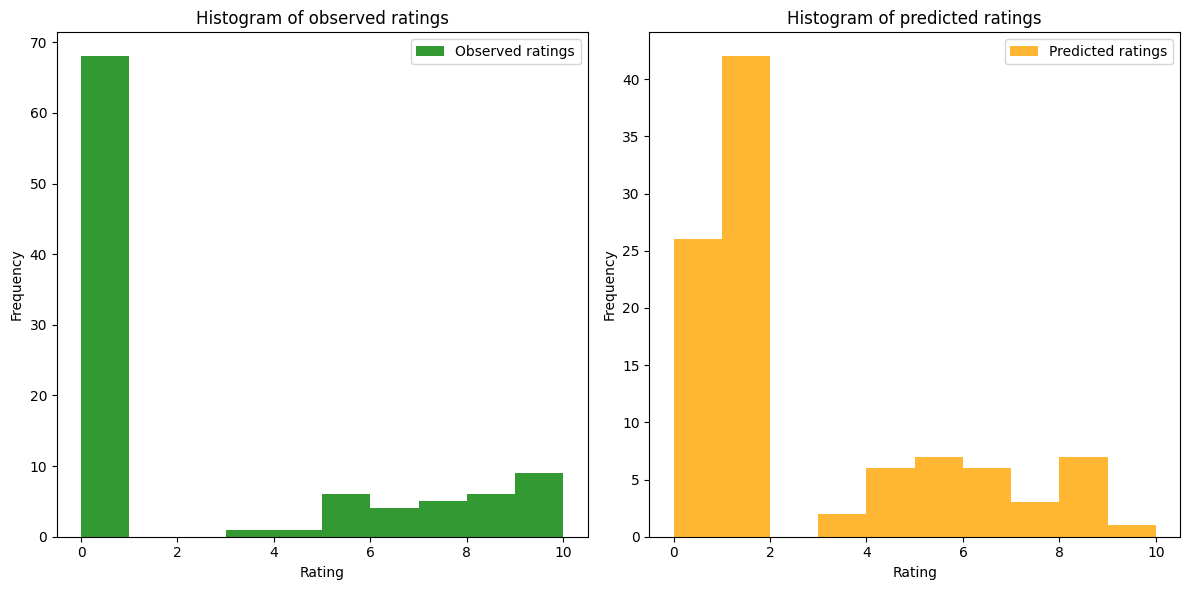

In [28]:
# I will plot histogram such that we'll easily see the difference between the
# initial (observed) interaction matrix and its predicted values 
plt.figure(figsize=(12, 6))

# make the first subplot -> the histogram representative for the observed interaction matrix
plt.subplot(1, 2, 1)
plt.hist(observed_ratings, bins=range(11), alpha=0.8, color='green', label='Observed ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Histogram of observed ratings')
plt.legend()

# second histogram -> predicted values in the interaction matrix
plt.subplot(1, 2, 2)
plt.hist(predicted_ratings, bins=range(11), alpha=0.8, color='orange', label='Predicted ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Histogram of predicted ratings')
plt.legend()

plt.tight_layout()
plt.show()

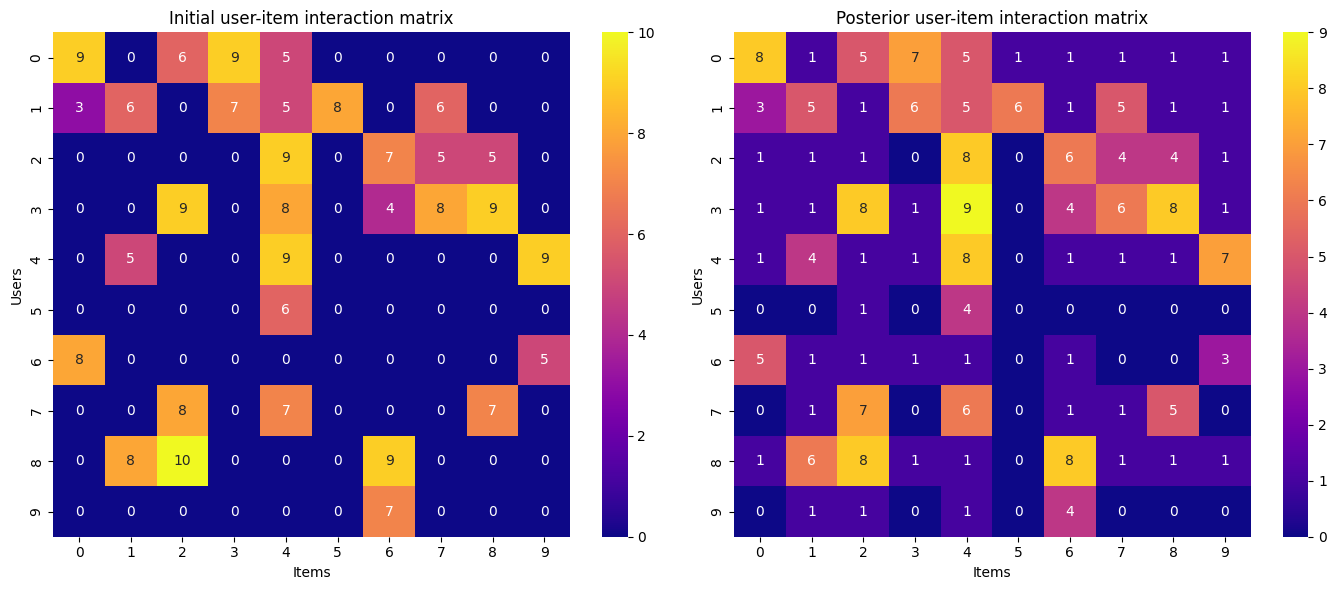

In [31]:
# I will plot coloe maps such that we'll easily see the difference between the
# initial (observed) interaction matrix and its predicted values 
plt.figure(figsize=(14, 6))

# make the first heatmap
plt.subplot(1, 2, 1)
sns.heatmap(int_matrix_arr_selected, cmap='plasma', annot=True)
# choose a title for the map
plt.title('Initial user-item interaction matrix')
plt.xlabel('Items')
plt.ylabel('Users')

# second heatmap, such that we can compare the initial ratings vs the predicted ones with the hpf model
plt.subplot(1, 2, 2)
sns.heatmap(rounded_mean_pred_ratings, cmap='plasma', annot=True)
# choose a title for the map
plt.title('Posterior user-item interaction matrix')
plt.xlabel('Items')
plt.ylabel('Users')

plt.tight_layout()
plt.show()

In [32]:
import arviz as az

In [33]:
# display info about the posterior distribution resulting 
# from the MCMC sampling process
az.summary(trace).round(2)

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
user_activity[0],0.42,0.32,0.02,0.96,0.01,0.00,1819.0,1356.0,1.00
user_activity[1],0.29,0.22,0.02,0.69,0.00,0.00,2052.0,1509.0,1.00
user_activity[2],0.57,0.40,0.05,1.29,0.01,0.01,2256.0,1265.0,1.00
user_activity[3],0.42,0.29,0.03,0.91,0.01,0.00,1861.0,1458.0,1.00
user_activity[4],0.56,0.41,0.02,1.30,0.01,0.01,2323.0,1265.0,1.00
...,...,...,...,...,...,...,...,...,...
"book_attribute[9, 5]",0.22,0.47,0.00,0.99,0.03,0.02,247.0,464.0,1.00
"book_attribute[9, 6]",0.66,1.77,0.00,3.35,0.13,0.09,211.0,239.0,1.00
"book_attribute[9, 7]",0.45,0.84,0.00,1.87,0.05,0.04,246.0,432.0,1.01
"book_attribute[9, 8]",0.51,1.14,0.00,2.42,0.07,0.05,202.0,565.0,1.00


In [34]:
# to evaluate the convergence of the model i extract the max rhat value
summary = pm.summary(trace)
rhats = summary['r_hat']
max_rhat = np.max(rhats)
print("max r-hat:", max_rhat)

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


max r-hat: 1.04


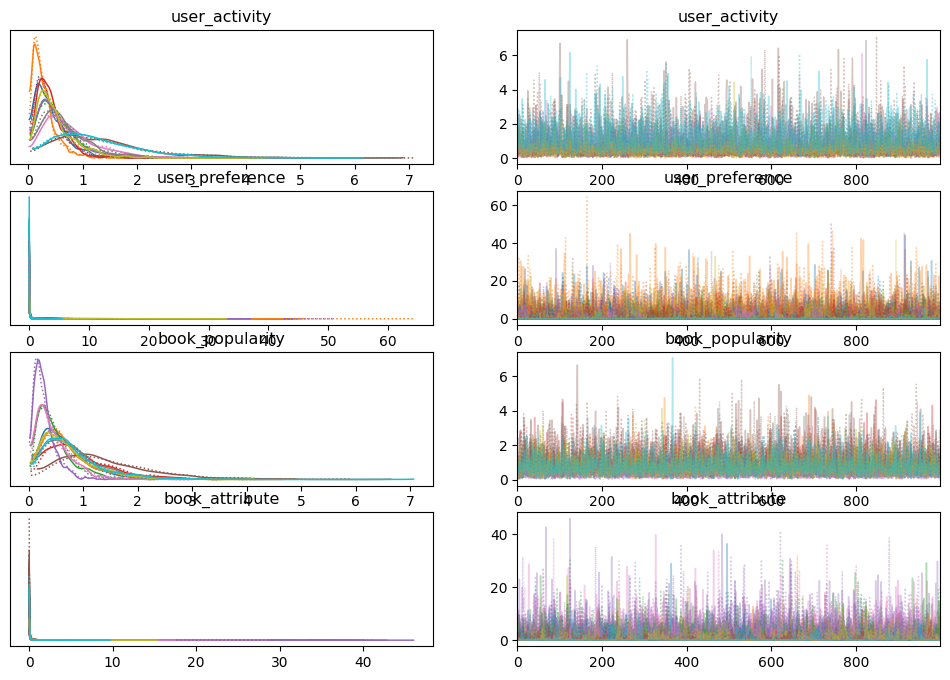

In [35]:
# code to visually inspect the traces of the MCMC samples 
# we can observe that there are no divergence points (would be indicated with some black vertical lines)
with pm.Model():
    az.plot_trace(trace)

#### Section 4. Parameters tuning for the previous model

Various tests were run with multiple parameters in order to improve the performance in the sanity check. Parameter tuning will be presented in the next cells. The role of the tuning was to help me find the best parameters for my HPF model. I will use RMSE metric in order to evaluate the model. 

In [42]:
# here I store the dictionary that will have as key the pair of tune-gamma paremeters for a specific run and as values the RMSE score for evaluation 
# and also another dictionary that would store the maximum r-hat achieved in a run for specific parameters
rmse_scores_dict = {}
max_rhat_dict = {}

In [43]:
# Find the best 'tune' parameter.
tune_param_to_test = [500, 1000, 1250, 1500]
gamma_to_test = [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 1, 1.5]

for tune_value in tune_param_to_test:
    for gamma_value in gamma_to_test:
        # I define the following hyperparameters that will be used in distributions
        # (I follow the same pattern as in the cited article from the project instructions)
        a_prime, b_prime, c_prime, d_prime = gamma_value, gamma_value, gamma_value, gamma_value
        a, b, c, d = gamma_value, gamma_value, gamma_value, gamma_value

        # I had to define a start dictionary that stores the necessary initial values
        # that MCMC algorithm will use at the very beginning (for the initial steps)
        # this were mostly determined through trial and error and adapted for my subset
        mcmc_start = {
            'user_activity': np.ones(n_users),
            'book_popularity': np.ones(n_items),
            'user_preference': np.ones((n_users, n_items)),
            'book_attribute': np.ones((n_items, n_items)),
        }


        # create the context for the Hierarchical Poisson Factorization (HPF) model
        with pm.Model() as hpf_model:
            # defining the user activity as a Gamma dist following the structure presented in the 
            # cited article from the project's grading (aplha is a_prime, beta is the a_prime/b_prime)
            user_activity = pm.Gamma('user_activity', alpha=a_prime, beta=a_prime/b_prime, shape=n_users, testval=mcmc_start['user_activity'])
            # next I define user_preference as indicated, following the hierarchical structure
            user_preference = pm.Gamma('user_preference', alpha=a, beta=user_activity, shape=(n_users, n_items), testval=mcmc_start['user_preference'])

            # the same thing for the books (items)
            # I use c, c_prime and d_prime to be consistent with the article's syntax
            book_popularity = pm.Gamma('book_popularity', alpha=c_prime, beta=c_prime/d_prime, shape=n_items, testval=mcmc_start['book_popularity'])
            book_attribute = pm.Gamma('book_attribute', alpha=c, beta=book_popularity, shape=(n_items, n_items), testval=mcmc_start['book_attribute'])
            
            # after computing the previous variables, we can determine the sample rating
            # first we compute the dot product between the user_preferenced's traspose and the book_attribute)
            # compute the sample rating as specified in the paper, using a Poisson dist
            scalar_prod = pm.math.dot(user_preference.T, book_attribute)
            interactions = pm.Poisson('interactions', mu=scalar_prod, observed=obs_data)

            # I reached the MCMC sampling part, where the parameters were tuned accordingly
            trace = pm.sample(1000, tune=500, cores=2, return_inferencedata=False, target_accept=0.90, initvals=mcmc_start)

            # generate samples from the posterior predicted dist for testing
            post_predictive = pm.sample_posterior_predictive(trace)
            # extract 'simulated' data from the model for testing
            likelihood = post_predictive['interactions']
            
            pred_ratings = np.mean(likelihood, axis=0)

            # here I compute the RMSE score between observed data (initial interaction matrix and the mean of predicted ratings)
            rmse_score = np.sqrt(mean_squared_error(obs_data, pred_ratings))
            rmse_scores_dict[f'tune={tune_value}, gamma={gamma_value}'] = rmse_score

            summ = pm.summary(trace)
            max_rhat = summ['r_hat'].max()
            max_rhat_dict[f'tune={tune_value}, gamma={gamma_value}'] = max_rhat


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [book_attribute, book_popularity, user_preference, user_activity]


/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 52 seconds.
There were 813 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7914391990087862, but should be close to 0.9. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 803 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [book_attribute, book_popularity, user_preference, user_activity]


/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 74 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [book_attribute, book_popularity, user_preference, user_activity]


/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 37 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [book_attribute, book_popularity, user_preference, user_activity]


/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 17 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [book_attribute, book_popularity, user_preference, user_activity]


/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 13 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [book_attribute, book_popularity, user_preference, user_activity]


/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 11 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [book_attribute, book_popularity, user_preference, user_activity]


/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 9 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [book_attribute, book_popularity, user_preference, user_activity]


/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 8 seconds.
The number of effective samples is smaller than 25% for some parameters.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [book_attribute, book_popularity, user_preference, user_activity]


/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 7 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [book_attribute, book_popularity, user_preference, user_activity]


/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 38 seconds.
There were 924 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.725267749661303, but should be close to 0.9. Try to increase the number of tuning steps.
There were 951 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7607849303607468, but should be close to 0.9. Try to increase the number of tuning steps.
The rhat statistic 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [book_attribute, book_popularity, user_preference, user_activity]


/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 75 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [book_attribute, book_popularity, user_preference, user_activity]


/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 40 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [book_attribute, book_popularity, user_preference, user_activity]


/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 18 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [book_attribute, book_popularity, user_preference, user_activity]


/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 11 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [book_attribute, book_popularity, user_preference, user_activity]


/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 13 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [book_attribute, book_popularity, user_preference, user_activity]


/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 8 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [book_attribute, book_popularity, user_preference, user_activity]


/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 8 seconds.
The number of effective samples is smaller than 25% for some parameters.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [book_attribute, book_popularity, user_preference, user_activity]


/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 7 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [book_attribute, book_popularity, user_preference, user_activity]


/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 36 seconds.
There were 918 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7379491953418983, but should be close to 0.9. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 904 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [book_attribute, book_popularity, user_preference, user_activity]


/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 75 seconds.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [book_attribute, book_popularity, user_preference, user_activity]


/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 36 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [book_attribute, book_popularity, user_preference, user_activity]


/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 17 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [book_attribute, book_popularity, user_preference, user_activity]


/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 11 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [book_attribute, book_popularity, user_preference, user_activity]


/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 10 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [book_attribute, book_popularity, user_preference, user_activity]


/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 8 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [book_attribute, book_popularity, user_preference, user_activity]


/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 7 seconds.
The number of effective samples is smaller than 25% for some parameters.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [book_attribute, book_popularity, user_preference, user_activity]


/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 7 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [book_attribute, book_popularity, user_preference, user_activity]


/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 58 seconds.
There were 683 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8065663185695546, but should be close to 0.9. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 891 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [book_attribute, book_popularity, user_preference, user_activity]


/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 70 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [book_attribute, book_popularity, user_preference, user_activity]


/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 37 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [book_attribute, book_popularity, user_preference, user_activity]


/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 17 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [book_attribute, book_popularity, user_preference, user_activity]


/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 11 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [book_attribute, book_popularity, user_preference, user_activity]


/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 11 seconds.
The number of effective samples is smaller than 25% for some parameters.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [book_attribute, book_popularity, user_preference, user_activity]


/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 8 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [book_attribute, book_popularity, user_preference, user_activity]


/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 8 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [book_attribute, book_popularity, user_preference, user_activity]


/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 7 seconds.


In [44]:
print(rmse_scores_dict)

{'tune=500, gamma=0.01': 0.45510119479078504, 'tune=500, gamma=0.05': 0.3963149000479291, 'tune=500, gamma=0.1': 0.46967953702498044, 'tune=500, gamma=0.3': 0.9765243673355007, 'tune=500, gamma=0.5': 1.4195947819712498, 'tune=500, gamma=0.7': 1.7483689649213063, 'tune=500, gamma=0.9': 2.0366830208699636, 'tune=500, gamma=1': 2.153158005117135, 'tune=500, gamma=1.5': 2.628287145652088, 'tune=1000, gamma=0.01': 0.45491745679848344, 'tune=1000, gamma=0.05': 0.3581277984183859, 'tune=1000, gamma=0.1': 0.4566468985989065, 'tune=1000, gamma=0.3': 0.9830120345143287, 'tune=1000, gamma=0.5': 1.410928427490211, 'tune=1000, gamma=0.7': 1.7530052238940992, 'tune=1000, gamma=0.9': 2.0405325279201016, 'tune=1000, gamma=1': 2.1549885133104536, 'tune=1000, gamma=1.5': 2.6253748403799406, 'tune=1250, gamma=0.01': 0.6513394161264924, 'tune=1250, gamma=0.05': 0.3819624719785963, 'tune=1250, gamma=0.1': 0.45722499111487774, 'tune=1250, gamma=0.3': 0.9785197698564909, 'tune=1250, gamma=0.5': 1.40635555248

In [45]:
key_for_min_rmse = min(rmse_scores_dict, key=rmse_scores_dict.get)
min_rmse_value = rmse_scores_dict[key_for_min_rmse]

print(f"Minimum RMSE: {min_rmse_value} for key: {key_for_min_rmse}")

Minimum RMSE: 0.3581277984183859 for key: tune=1000, gamma=0.05


In [46]:
key_for_min_max_rhat = min(max_rhat_dict, key=max_rhat_dict.get)
min_rhat_value = max_rhat_dict[key_for_min_max_rhat]

print(f"Minimum R-hat: {min_rhat_value} for key: {key_for_min_max_rhat}")

Minimum R-hat: 1.0 for key: tune=1000, gamma=1.5


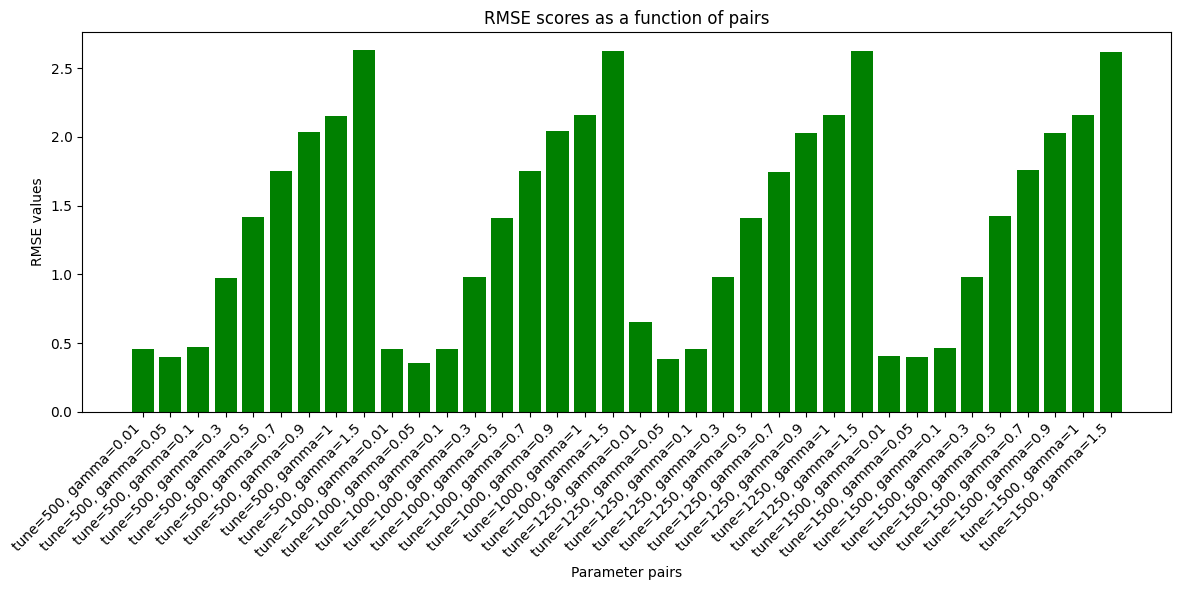

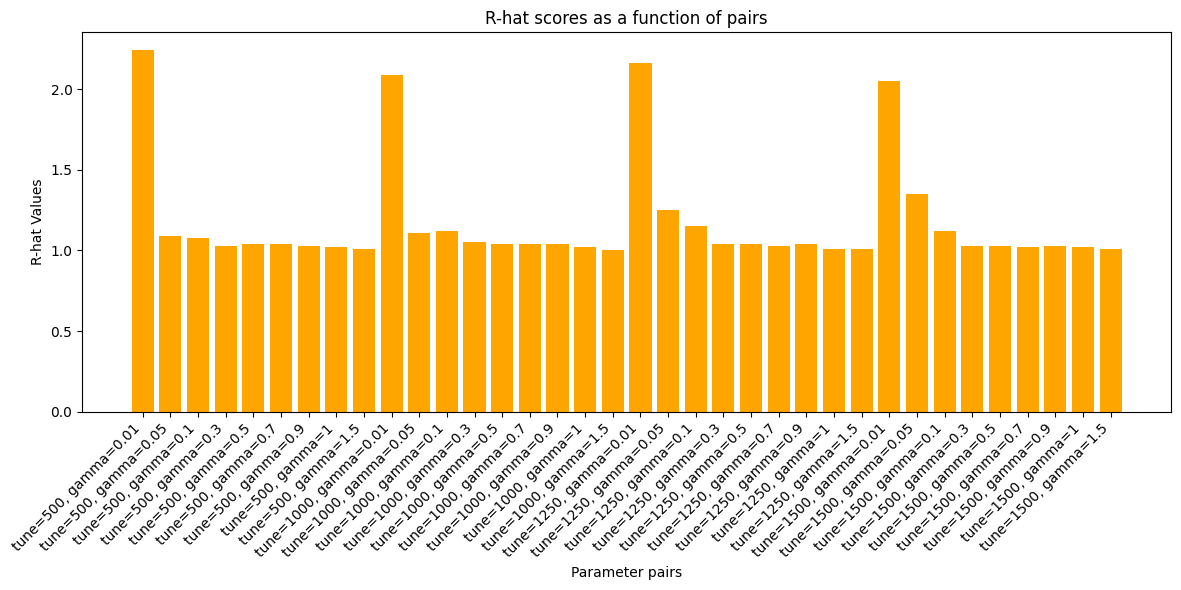

In [47]:
x_val = list(rmse_scores_dict.keys())

# Plotting RMSE
rmse_values = list(rmse_scores_dict.values())
plt.figure(figsize=(12, 6))
plt.bar(x_val, rmse_values, color='green')
plt.xlabel('Parameter pairs')
plt.ylabel('RMSE values')
plt.title('RMSE scores as a function of pairs')
plt.xticks(rotation=45, ha='right') 
plt.tight_layout()
plt.show()

# Plotting R-hat
rhat_values = list(max_rhat_dict.values())
plt.figure(figsize=(12, 6))
plt.bar(x_val, rhat_values, color='orange')
plt.xlabel('Parameter pairs')
plt.ylabel('R-hat Values')
plt.title('R-hat scores as a function of pairs')
plt.xticks(rotation=45, ha='right') 
plt.tight_layout()
plt.show()

To be sure that the model will converge for a bigger dataset, I will select the equilibrum point between min RMSE score and min Max-Rhat score, meaning that for the final model I will use tune=1000 and gamma=0.1. I observed that strangely they follow a ciclic pattern.

#### Section 5. The choice of X users and Y books

I started by taking a closer look at our data.

First, I computed the user which gave the most ratings.

In [119]:
# compute the number of ratings for each user
user_ratings_counts = all_ratings_df['User-ID'].value_counts()
# we want to filter out users with zero ratings
non_zero_ratings_counts = user_ratings_counts[user_ratings_counts > 0]
# then we can find the user with the most non-zero ratings
user_with_most_non_zero_ratings = non_zero_ratings_counts.idxmax()
# compute the number of non-zero ratings given by the user with the most ratings
most_non_zero_ratings_count = non_zero_ratings_counts.max()

print(f"User with the most non-zero ratings is {user_with_most_non_zero_ratings} with {most_non_zero_ratings_count} non-zero ratings.")

User with the most non-zero ratings is 11676 with 13602 non-zero ratings.


Process the mean number of ratings given by all users.

In [120]:
# determine the mean number of ratings (including 0s)
mean_ratings_per_user = user_ratings_counts.mean()
# print the result 
print(f"The mean number of ratings per user is: {mean_ratings_per_user}")

The mean number of ratings per user is: 10.921079376537522


I also wanted to compute the second user having most ratings given.

In [121]:
# line of code to exclude the user with the most ratings
ratings_df_excluded_max_user = all_ratings_df[all_ratings_df['User-ID'] != user_with_most_non_zero_ratings]
# compute the counts of ratings for each user in df, without the most popular user
user_ratings_counts_excluded_max_user = ratings_df_excluded_max_user['User-ID'].value_counts()
non_zero_ratings_counts_excluded_max_user = user_ratings_counts_excluded_max_user[user_ratings_counts_excluded_max_user > 0]
# find the user ID with the second most ratings
user_with_second_most_ratings = non_zero_ratings_counts_excluded_max_user.idxmax()
# number ratings given by the user with the second most ratings
second_most_non_zero_ratings_count = user_ratings_counts_excluded_max_user.max()
print(f"User with the second most ratings is {user_with_second_most_ratings} with {second_most_non_zero_ratings_count} non-zero ratings.")

User with the second most ratings is 198711 with 7550 non-zero ratings.


Then I wanted to discover the book having the most ratings.

In [122]:
# same strategy as before
book_ratings_counts = all_ratings_df['ISBN'].value_counts()
non_zero_book_ratings_counts = book_ratings_counts[book_ratings_counts > 0]
# actually select the book with the most ratings
book_with_most_ratings = non_zero_book_ratings_counts.idxmax()
# compute the number of ratings received by the book with the most ratings
most_ratings_for_book_count = non_zero_book_ratings_counts.max()

print(f"Book with the most ratings (non-zero) is {book_with_most_ratings} with {most_ratings_for_book_count} ratings.")

Book with the most ratings (non-zero) is 0971880107 with 2502 ratings.


This is the computation of the mean ratings per book.

In [123]:
mean_ratings_per_book = book_ratings_counts.mean()
print(f"The mean number of ratings per book is: {mean_ratings_per_book}")

The mean number of ratings per book is: 3.376255300156215


Then what I did was to filter the instances in the dataset based on custom filters that I've made, in order to find some correlations in the data.

In [124]:
# I will filter users with at least 10 ratings (the mean) and at most 100 non-zero ratings
filtered_users = user_ratings_counts[(user_ratings_counts >= 10) & (user_ratings_counts[user_ratings_counts.index] <= 100)].index
filtered_users_df = all_users_df[all_users_df['User-ID'].isin(filtered_users)].drop_duplicates(subset=['User-ID']) # this keeps only the unique users
filtered_users_df = filtered_users_df.sample(n=620, random_state=1) # choose random samples from the ones already filtered

# here I filter books with at least 3 ratings (the mean) and at most 100 ratings
book_ratings_counts = all_ratings_df['ISBN'].value_counts()
filtered_books = book_ratings_counts[(book_ratings_counts >= 3) & (book_ratings_counts <= 100)].index
filtered_books_df = all_books_df[all_books_df['ISBN'].isin(filtered_books)].drop_duplicates(subset=['ISBN']) # this keeps only the unique books from that range
filtered_books_df = filtered_books_df.sample(n=620, random_state=1)

# merge filtered data to further create the interaction matrix
filtered_ratings_df = all_ratings_df[(all_ratings_df['User-ID'].isin(filtered_users)) & (all_ratings_df['ISBN'].isin(filtered_books))]
filtered_merged_df = pd.merge(filtered_ratings_df, filtered_users_df, on='User-ID')
filtered_merged_df = pd.merge(filtered_merged_df, filtered_books_df, on='ISBN')

# create the filtered interatction matrix that will be used as observed data
filtered_interaction_matrix = filtered_merged_df.pivot_table(index='User-ID', columns='ISBN', values='Book-Rating')
filtered_interaction_matrix = filtered_interaction_matrix.fillna(0)  

n_f_users, n_f_items = filtered_interaction_matrix.shape

# because always n_f_items > n_f_users 
items_to_keep = np.random.choice(filtered_interaction_matrix.columns, size=n_f_users)
# keep only the selected items
filtered_interaction_matrix = filtered_interaction_matrix[items_to_keep]
# here I update the number of items
n_f_items = n_f_users

In [125]:
print(n_f_users, n_f_items)
print(filtered_interaction_matrix.shape)

62 62
(62, 62)


#### Section 6. Final model

Now that we finished with the sanity check and to choose the X users (X=62) and Y books (Y=62), I will provide the code (which is really similar to the previous one) for the new bigger chosen dataset. Basically the observed data is changed.

In [126]:
# I define the following hyperparameters that will be used in distributions
# (I follow the same pattern as in the cited article from the project instructions)
a_prime, b_prime, c_prime, d_prime = 0.1, 0.1, 0.1, 0.1
a, b, c, d = 0.1, 0.1, 0.1, 0.1


# I had to define a start dictionary that stores the necessary initial values
# that MCMC algorithm will use at the very beginning (for the initial steps)
# this were mostly determined through trial and error and adapted for my subset
mcmc_start = {
    'user_activity': np.ones(n_f_users),
    'book_popularity': np.ones(n_f_items),
    'user_preference': np.ones((n_f_users, n_f_items)),
    'book_attribute': np.ones((n_f_items, n_f_items)),
}


# create the context for the Hierarchical Poisson Factorization (HPF) model
with pm.Model() as hpf_model:
    # defining the user activity as a Gamma dist following the structure presented in the 
    # cited article from the project's grading (aplha is a_prime, beta is the a_prime/b_prime)
    user_activity = pm.Gamma('user_activity', alpha=a_prime, beta=a_prime/b_prime, shape=n_f_users, testval=mcmc_start['user_activity'])
    # next I define user_preference as indicated, following the hierarchical structure
    user_preference = pm.Gamma('user_preference', alpha=a, beta=user_activity, shape=(n_f_users, n_f_items), testval=mcmc_start['user_preference'])

    # the same thing for the books (items)
    # I use c, c_prime and d_prime to be consistent with the article's syntax
    book_popularity = pm.Gamma('book_popularity', alpha=c_prime, beta=c_prime/d_prime, shape=n_f_items, testval=mcmc_start['book_popularity'])
    book_attribute = pm.Gamma('book_attribute', alpha=c, beta=book_popularity, shape=(n_f_users, n_f_items), testval=mcmc_start['book_attribute'])
    
    # after computing the previous variables, we can determine the sample rating
    # first we compute the dot product between the user_preferenced's traspose and the book_attribute)
    # compute the sample rating as specified in the paper, using a Poisson dist
    scalar_prod = pm.math.dot(user_preference.T, book_attribute)
    interactions = pm.Poisson('interactions', mu=scalar_prod, observed=filtered_interaction_matrix)

    # I reached the MCMC sampling part, where the parameters were tuned accordingly
    trace_final = pm.sample(3000, tune=1000, cores=2, return_inferencedata=False, target_accept=0.95, initvals=mcmc_start)

    # generate samples from the posterior predicted dist for testing
    post_predictive_f = pm.sample_posterior_predictive(trace_final)
    # extract 'simulated' data from the model for testing
    likelihood_final = post_predictive_f['interactions']

# this is standard syntax to extract latent factors from the trace
user_preference_sample_f = trace_final['user_preference']
book_attribute_samples_f = trace_final['book_attribute']

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [book_attribute, book_popularity, user_preference, user_activity]


/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 445 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [127]:
print(user_preference_sample_f.shape)

(6000, 62, 62)


In [128]:
# here i wanted to compute from those 3000 samples generated
# the mean rating obtained for each user-item pair
mean_pred_ratings_final = np.mean(likelihood_final, axis=0)
rounded_mean_pred_ratings_final = np.round(mean_pred_ratings_final)
print(rounded_mean_pred_ratings_final)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [129]:
print(likelihood_final.shape)

(6000, 62, 62)


In [130]:
# we will compare the intial (observed) ratings with the predicted ones
observed_ratings_f = filtered_interaction_matrix.values.flatten()
predicted_ratings_f = rounded_mean_pred_ratings_final.flatten()

# compute the Root Mean Squared error between those 2
rmse = sqrt(mean_squared_error(observed_ratings_f, predicted_ratings_f))
# simply print it. the obtained value is reasonable for our case
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 0.34252839647734357


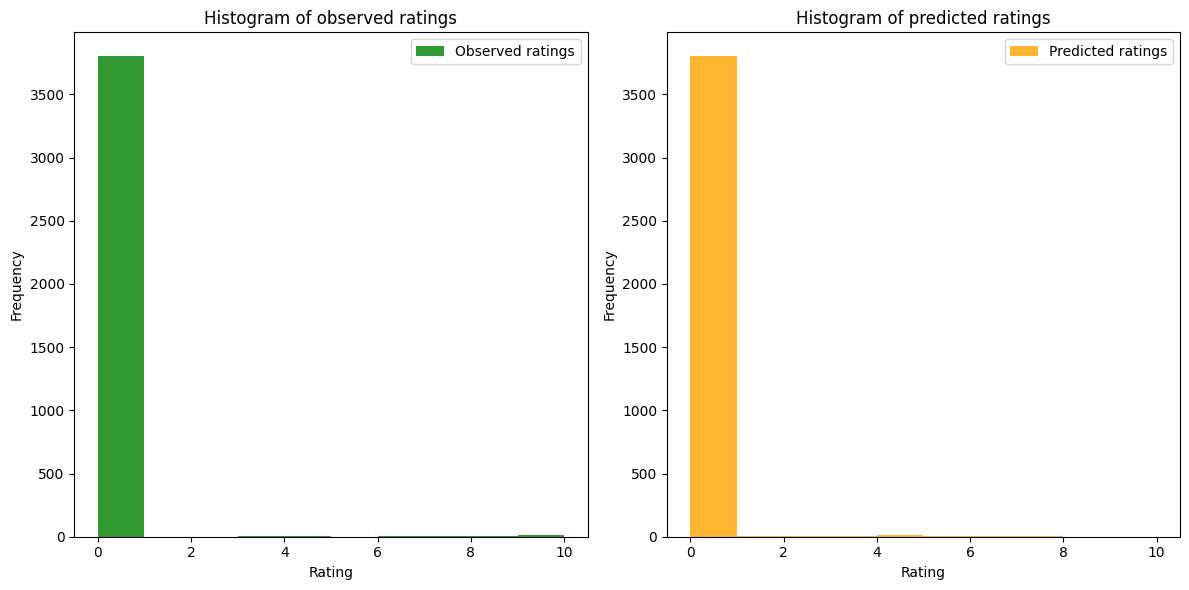

In [131]:
# I will plot histogram such that we'll easily see the difference between the
# initial (observed) interaction matrix and its predicted values 
plt.figure(figsize=(12, 6))

# make the first subplot -> the histogram representative for the observed interaction matrix
plt.subplot(1, 2, 1)
plt.hist(observed_ratings_f, bins=range(11), alpha=0.8, color='green', label='Observed ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Histogram of observed ratings')
plt.legend()

# second histogram -> predicted values in the interaction matrix
plt.subplot(1, 2, 2)
plt.hist(predicted_ratings_f, bins=range(11), alpha=0.8, color='orange', label='Predicted ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Histogram of predicted ratings')
plt.legend()

plt.tight_layout()
plt.show()

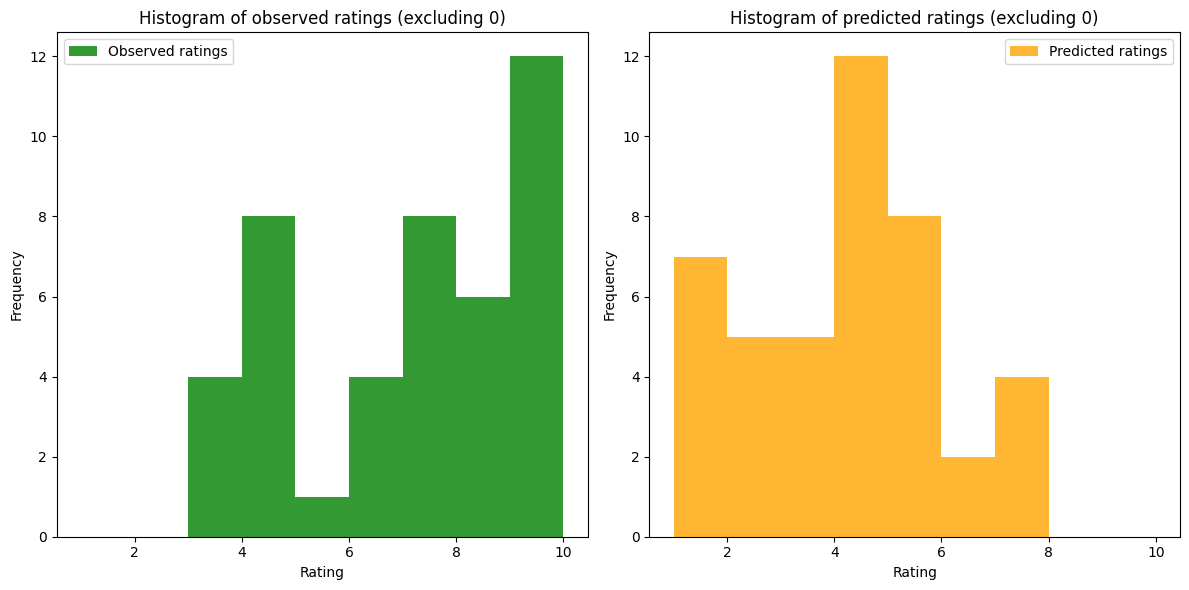

In [132]:
# IMPORTANT: Here I won't plot the corresponding frequency for the 0 values because it is too big compared to the others

# exclude 0 values from the observed and predicted ratings
observed_non_0 = [rating for rating in observed_ratings_f if rating != 0]
predicted_non_0 = [rating for rating in predicted_ratings_f if rating != 0]

# plotting histograms without 0 values
plt.figure(figsize=(12, 6))

# observed ratings histogram
plt.subplot(1, 2, 1)
plt.hist(observed_non_0, bins=range(1, 11), alpha=0.8, color='green', label='Observed ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Histogram of observed ratings (excluding 0)')
plt.legend()

# predicted ratings histogram
plt.subplot(1, 2, 2)
plt.hist(predicted_non_0, bins=range(1, 11), alpha=0.8, color='orange', label='Predicted ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Histogram of predicted ratings (excluding 0)')
plt.legend()

plt.tight_layout()
plt.show()

In [136]:
# display info about the posterior distribution resulting 
# from the MCMC sampling process
az.summary(trace_final).round(2)

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/oana/Downloads/pml-exam/master-AI/PP/.venv/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
user_activity[0],2.87,1.44,0.61,5.49,0.02,0.01,6279.0,4213.0,1.00
user_activity[1],2.85,1.40,0.61,5.46,0.02,0.01,5397.0,4465.0,1.00
user_activity[2],1.30,0.67,0.28,2.50,0.01,0.01,4810.0,4206.0,1.00
user_activity[3],2.84,1.40,0.61,5.42,0.02,0.01,4874.0,3967.0,1.00
user_activity[4],1.31,0.68,0.27,2.55,0.01,0.01,5210.0,4338.0,1.00
...,...,...,...,...,...,...,...,...,...
"book_attribute[61, 57]",0.03,0.09,0.00,0.13,0.00,0.00,2134.0,1713.0,1.00
"book_attribute[61, 58]",0.07,0.31,0.00,0.19,0.01,0.01,1228.0,809.0,1.01
"book_attribute[61, 59]",0.02,0.07,0.00,0.09,0.00,0.00,2032.0,1495.0,1.00
"book_attribute[61, 60]",0.03,0.10,0.00,0.11,0.00,0.00,1809.0,1455.0,1.00


The following piece of code will generate 2 interesting columns containing visualizations of the traces obtained by my hpf_model. On the left side we can see the samples of the parameter of interest over the course of the MCMC run, while on the right side the plots help us visually determine the likely values our parameter will take. 

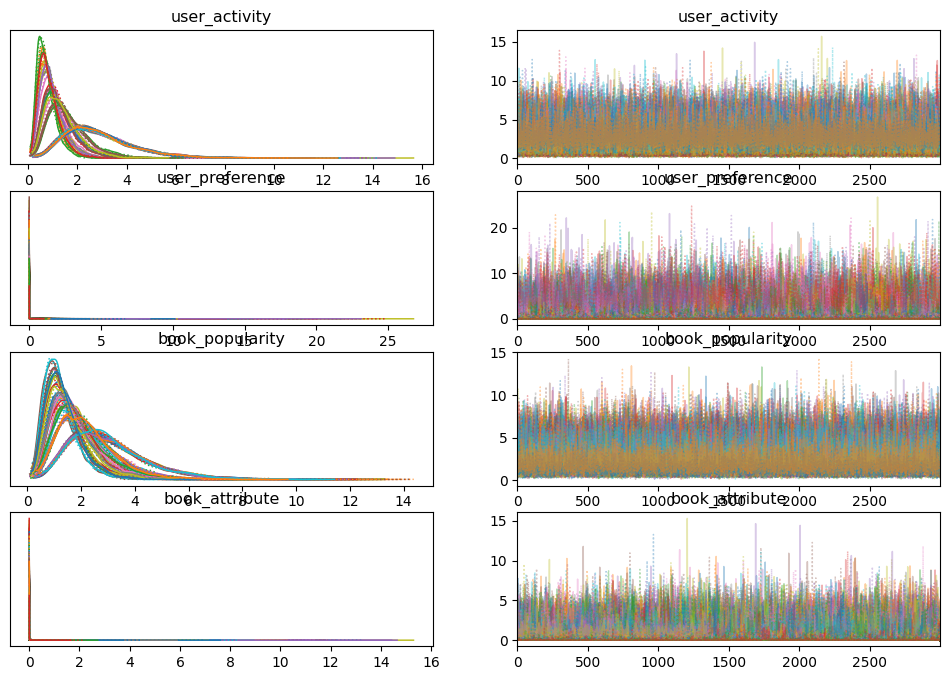

In [137]:
with pm.Model():
    az.plot_trace(trace_final)

#### Section 7. Conclusions

The obtained RMSE score for the model during the sanity check and final model was lower than 1, indicating that on average the predicted ratings are close to the observed ratings, as seen in the histogram and heatmap comparisons. Also the r-hat values analysed with the help of the summary(trace) indicate that, for good parameters found after tuning, our model converges. As a comparison between the sanity check and the final model, I want to mention that for both of them the RMSE metric indicates good behaviour in my testings. The final model may not have totally converged because the choice of the data, that maybe could have been done better. 

One other thing was that, if I increase the number of X users and Y items selected, the time needed for the MCMC algorithm to converge increased significantly. I attach the proof in the next cell (this is a screenshot from my previous trials). I observed that, for each values for X and Y greater than 64, the time needed for the MCMC algorithm to converge increases from a few minutes (as it is the case above) to more than 10 hours on average. My guess is that the available RAM on my machine is insufficient to accommodate an entire matrix with greater dimension, this causing the operating system to swap to disk. Accessing data from disk is much slower compared to accessing it from RAM and this leads to a significant performance decrease.

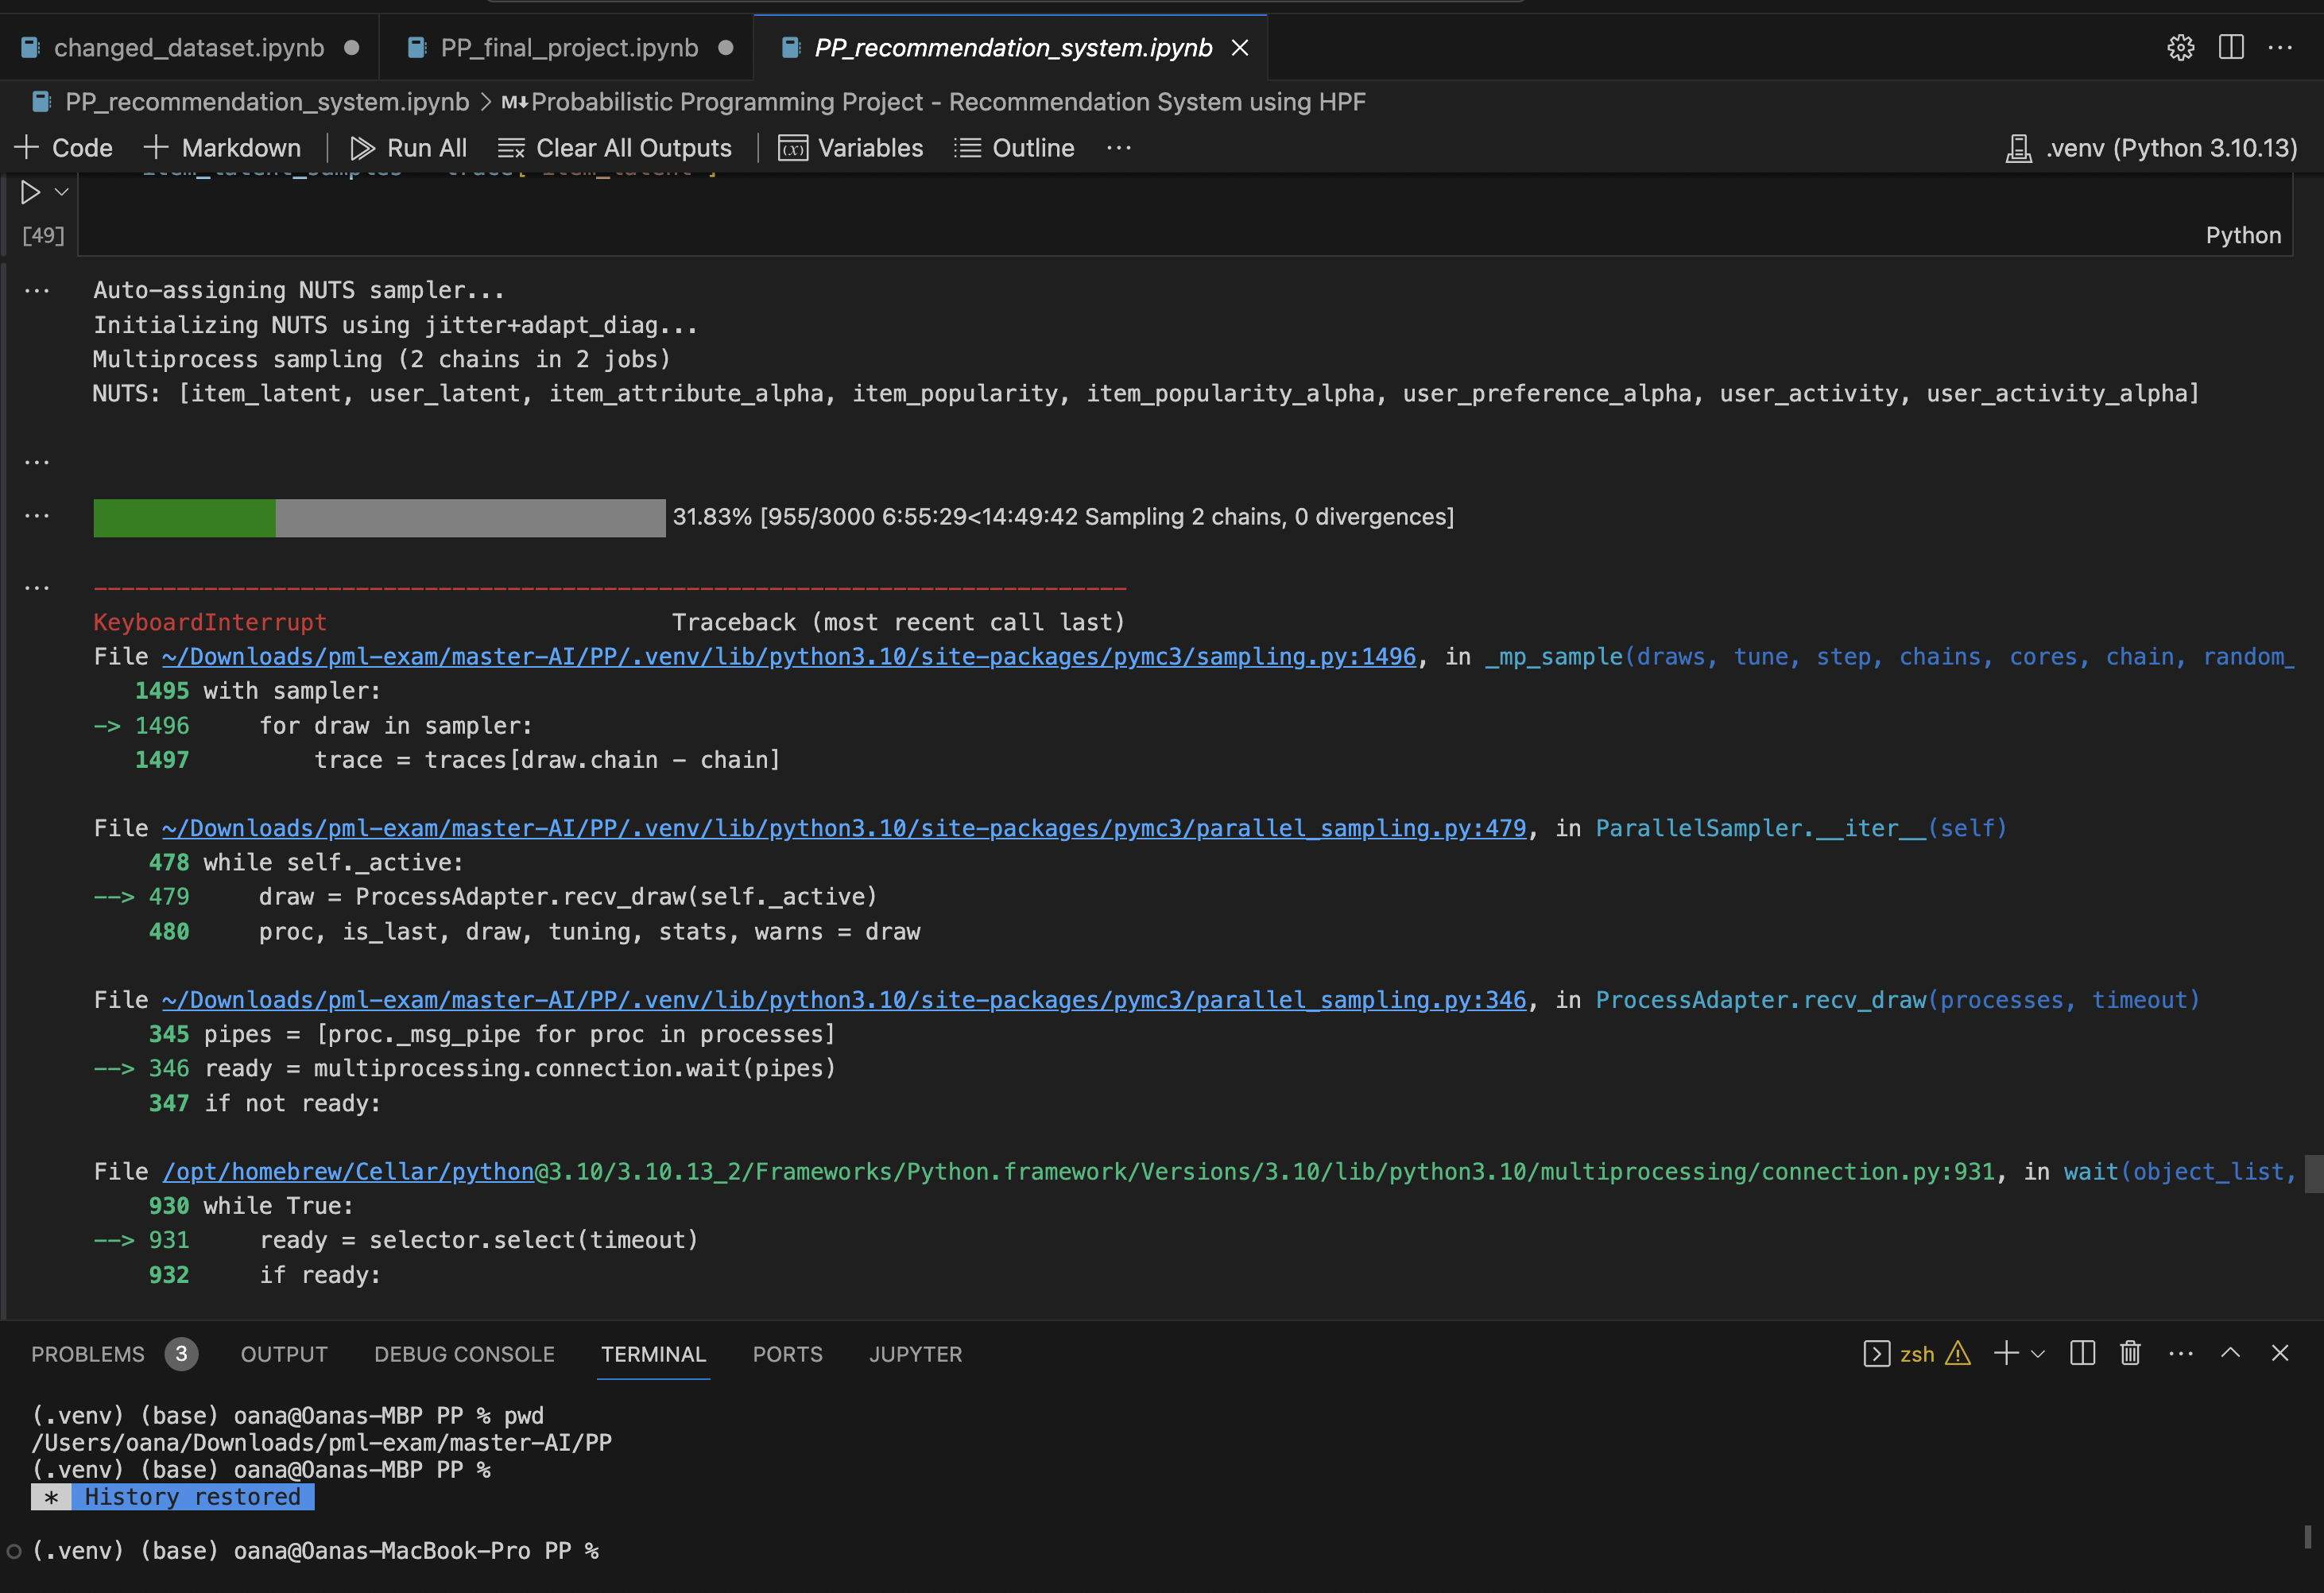

In [135]:
from IPython import display
display.Image("pp-proof.png")